In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data stability

In [2]:
MSA_dict = {'Baltimore-Columbia-Towson': 'Baltimore, MD', 'Boston-Cambridge-Newton': 'Boston, MA-NH', 
            'Champaign-Urbana': 'Champaign, IL', 'Cheyenne': 'Cheyenne, WY', 'Fresno': 'Fresno, CA', 
            'LosAngeles-LongBeach-Anaheim': 'Los Angeles, CA', 'NewYork-Newark-JerseyCity': 'New York, NY-NJ-PA',
            'Seattle-Tacoma-Bellevue': 'Seattle, WA', 'Sebring-AvonPark': 'Sebring, FL', 
            'Tulsa': 'Tulsa, OK', 'Tyler': 'Tyler, TX',
            'Baltimore': 'Baltimore, MD', 'Boston': 'Boston, MA-NH', 'Champaign': 'Champaign, IL',
            'Cheyenne': 'Cheyenne, WY', 'Fresno': 'Fresno, CA', 'LosAngeles': 'Los Angeles, CA',
            'NewYork': 'New York, NY-NJ-PA', 'Seattle': 'Seattle, WA', 'Sebring': 'Sebring, FL',
            'Tulsa': 'Tulsa, OK', 'Tyler': 'Tyler, TX'}

In [3]:
MSA_order = ['New York, NY-NJ-PA','Los Angeles, CA','Boston, MA-NH','Baltimore, MD',
 'Seattle, WA','Tulsa, OK','Fresno, CA','Tyler, TX','Champaign, IL',
 'Sebring, FL','Cheyenne, WY']

## Number of devices over time

In [4]:
daily_devices_df = pd.read_csv('Metrics/daily_devices.csv')
daily_devices_df['date'] = pd.to_datetime(daily_devices_df['date'])
# Define the date range, some dates in June seems to have issues, thus only Jan to May is shown, adjust if needed
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-31')
# Filter the data
daily_devices_df = daily_devices_df[
    (daily_devices_df['date'] >= start_date) & 
    (daily_devices_df['date'] <= end_date)
]
daily_devices_df['datetime'] = daily_devices_df['date']
daily_devices_df['date'] = daily_devices_df['date'].dt.date
daily_devices_df['MSA'] = daily_devices_df['MSA'].map(MSA_dict)
# sort the df by MSA_order
daily_devices_df['MSA'] = pd.Categorical(daily_devices_df['MSA'], categories=MSA_order, ordered=True)
daily_devices_df = daily_devices_df.sort_values('MSA')

In [5]:
# Custom palette
custom_palette = ['#800000', '#9A6324', '#808000', '#469990', '#000075', '#4363d8', '#911eb4', '#f032e6','#a9a9a9', '#ffd8b1', '#aaffc3']
palette = sns.color_palette(custom_palette)

In [6]:
# The population of each MSA is hard-coded here
population_data = {
    'Baltimore, MD': 2844510, 'Boston, MA-NH': 4900550,'Champaign, IL':236514,
    'Cheyenne, WY':100984, 'Fresno, CA':1171617,'Los Angeles, CA':12872322,
    'New York, NY-NJ-PA':22432947, 'Seattle, WA':4034248, 'Sebring, FL':105618,
    'Tulsa, OK':1034123, 'Tyler, TX':109286
}
daily_devices_df['population'] = daily_devices_df['MSA'].apply(lambda x:population_data[x])
daily_devices_df['population'] = daily_devices_df['population'].astype(int)
daily_devices_df['sampling_rate'] = daily_devices_df['num_of_device'] / daily_devices_df['population']
daily_devices_df['Average Sampling Rate'] = daily_devices_df.groupby('MSA')['sampling_rate'].transform('mean')
daily_devices_df['Average Sampling Rate'] = daily_devices_df['Average Sampling Rate']*100
daily_devices_df['MSA_Average Sampling Rate'] = daily_devices_df['MSA'].astype('string') + ' (' + daily_devices_df['Average Sampling Rate'].round(1).astype(str) + '%)'

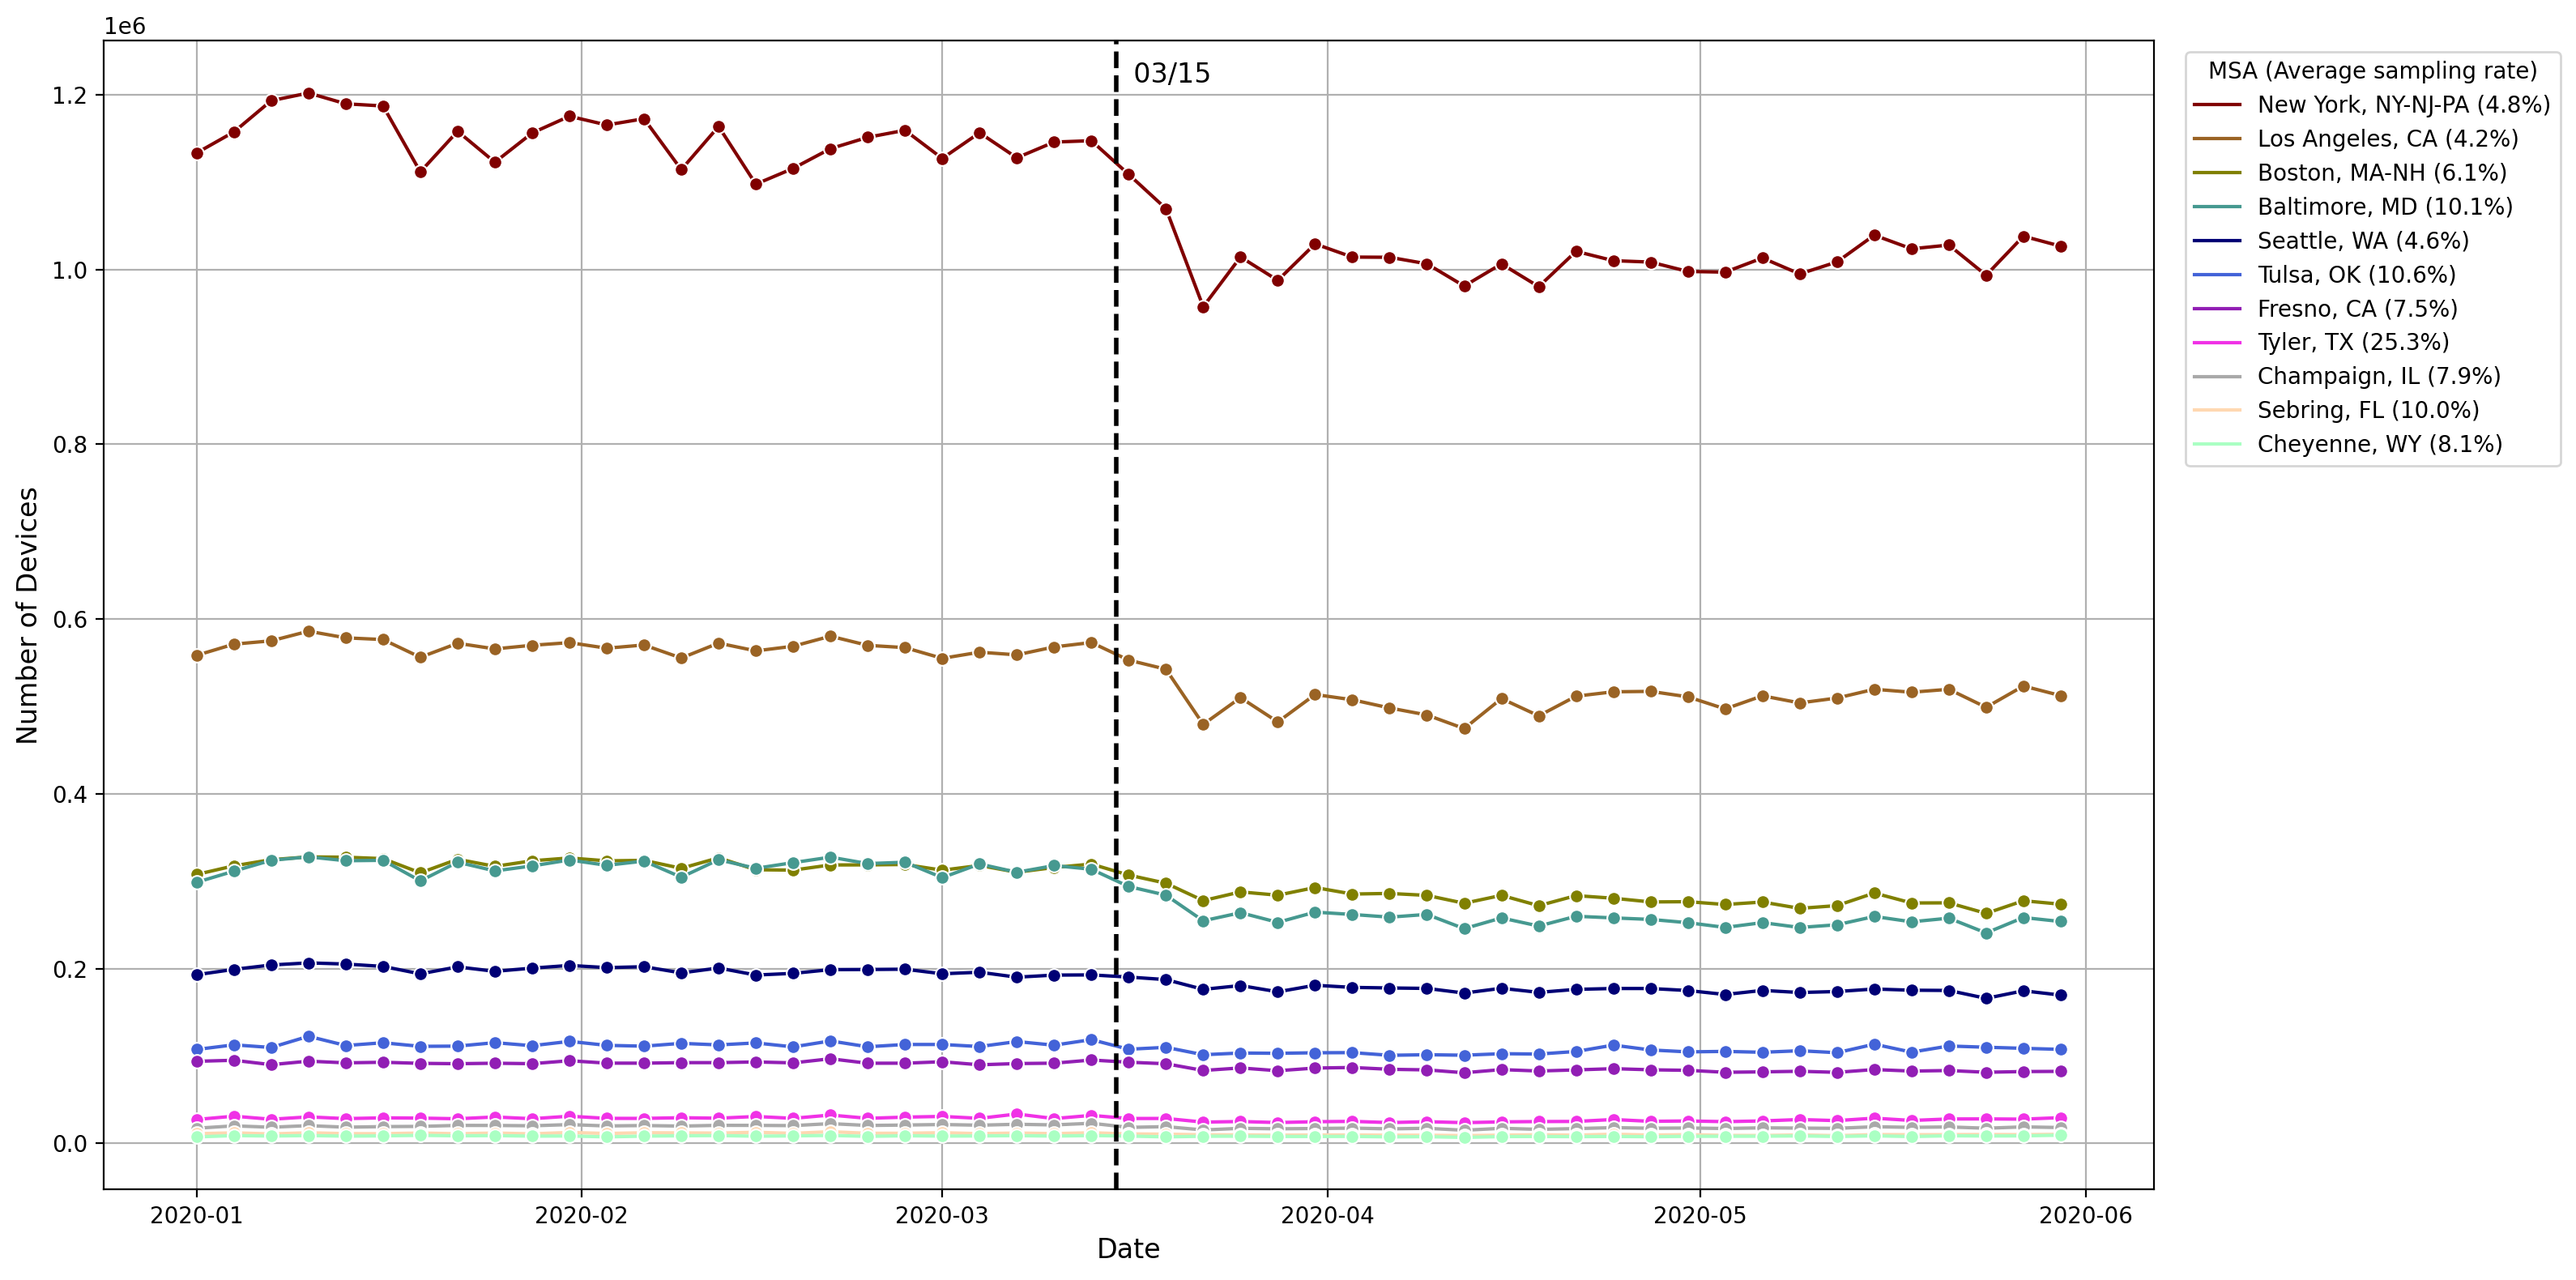

In [7]:
plt.figure(figsize=(16, 8), dpi=200)

# Plotting the line
plot_df = daily_devices_df[(daily_devices_df['datetime'] - pd.Timestamp('2020-01-01')).dt.days % 3 == 0]
sns.lineplot(data=plot_df, x='date', y='num_of_device', hue='MSA_Average Sampling Rate', palette=palette, linestyle='-',marker='o')

# plt.title('Number of Devices per Day for Each MSA Over Time')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='MSA (Average sampling rate)', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.axvline(pd.Timestamp('2020-03-15'), color='black', linestyle='--', lw=2)
plt.text(pd.Timestamp('2020-03-15'), daily_devices_df['num_of_device'].max() * 1.01, '  03/15', color='black', fontsize=12)

plt.grid(True)
plt.tight_layout()
# plt.savefig('Figures/Number_of_Devices_per_Day_for_Each_MSA_Over_Time.png')


If we want to check the sampling rate for each MSA

## Number of records per device over time

In [8]:
daily_metrics_df = pd.read_csv('Metrics/daily_metrics.csv')
daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
# Define the date range, some dates in June seems to have issues, thus only Jan to May is shown, adjust if needed
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-05-31')
# Filter the data
daily_metrics_df = daily_metrics_df[
    (daily_metrics_df['date'] >= start_date) & 
    (daily_metrics_df['date'] <= end_date)
]

In [9]:
date_range = pd.date_range(start=daily_metrics_df['date'].min(), end=daily_metrics_df['date'].max(), freq='D')
user_ids = daily_metrics_df['user_id'].unique()
unique_users = daily_metrics_df['user_id'].unique()
unique_msa = daily_metrics_df['MSA'].unique()

date_range = pd.date_range(start=daily_metrics_df['date'].min(), end=daily_metrics_df['date'].max(), freq='D')
# Map user_id to MSA directly to avoid unnecessary combinations
user_msa_map = daily_metrics_df[['user_id', 'MSA']].drop_duplicates().set_index('user_id')
# Create a DataFrame with all date and user_id combinations
all_dates = pd.DataFrame(date_range, columns=['date'])
all_users = pd.DataFrame(user_msa_map.index.unique(), columns=['user_id'])
user_dates = pd.merge(all_dates.assign(key=1), all_users.assign(key=1), on='key').drop('key', axis=1)
# Add MSA to each user-date combination
complete_data = user_dates.join(user_msa_map, on='user_id')
# Merge with the original records and fill missing data
daily_metrics_df_complete = complete_data.merge(daily_metrics_df, on=['date', 'user_id', 'MSA'], how='left').fillna(0)
daily_metrics_df_complete['datetime'] = daily_metrics_df_complete['date']
daily_metrics_df_complete['date'] = daily_metrics_df_complete['date'].dt.date
daily_metrics_df_complete['MSA'] = daily_metrics_df_complete['MSA'].map(MSA_dict)
# sort the df by MSA_order
daily_metrics_df_complete['MSA'] = pd.Categorical(daily_metrics_df_complete['MSA'], categories=MSA_order, ordered=True)

Exclude devices with 0 record whithin that day

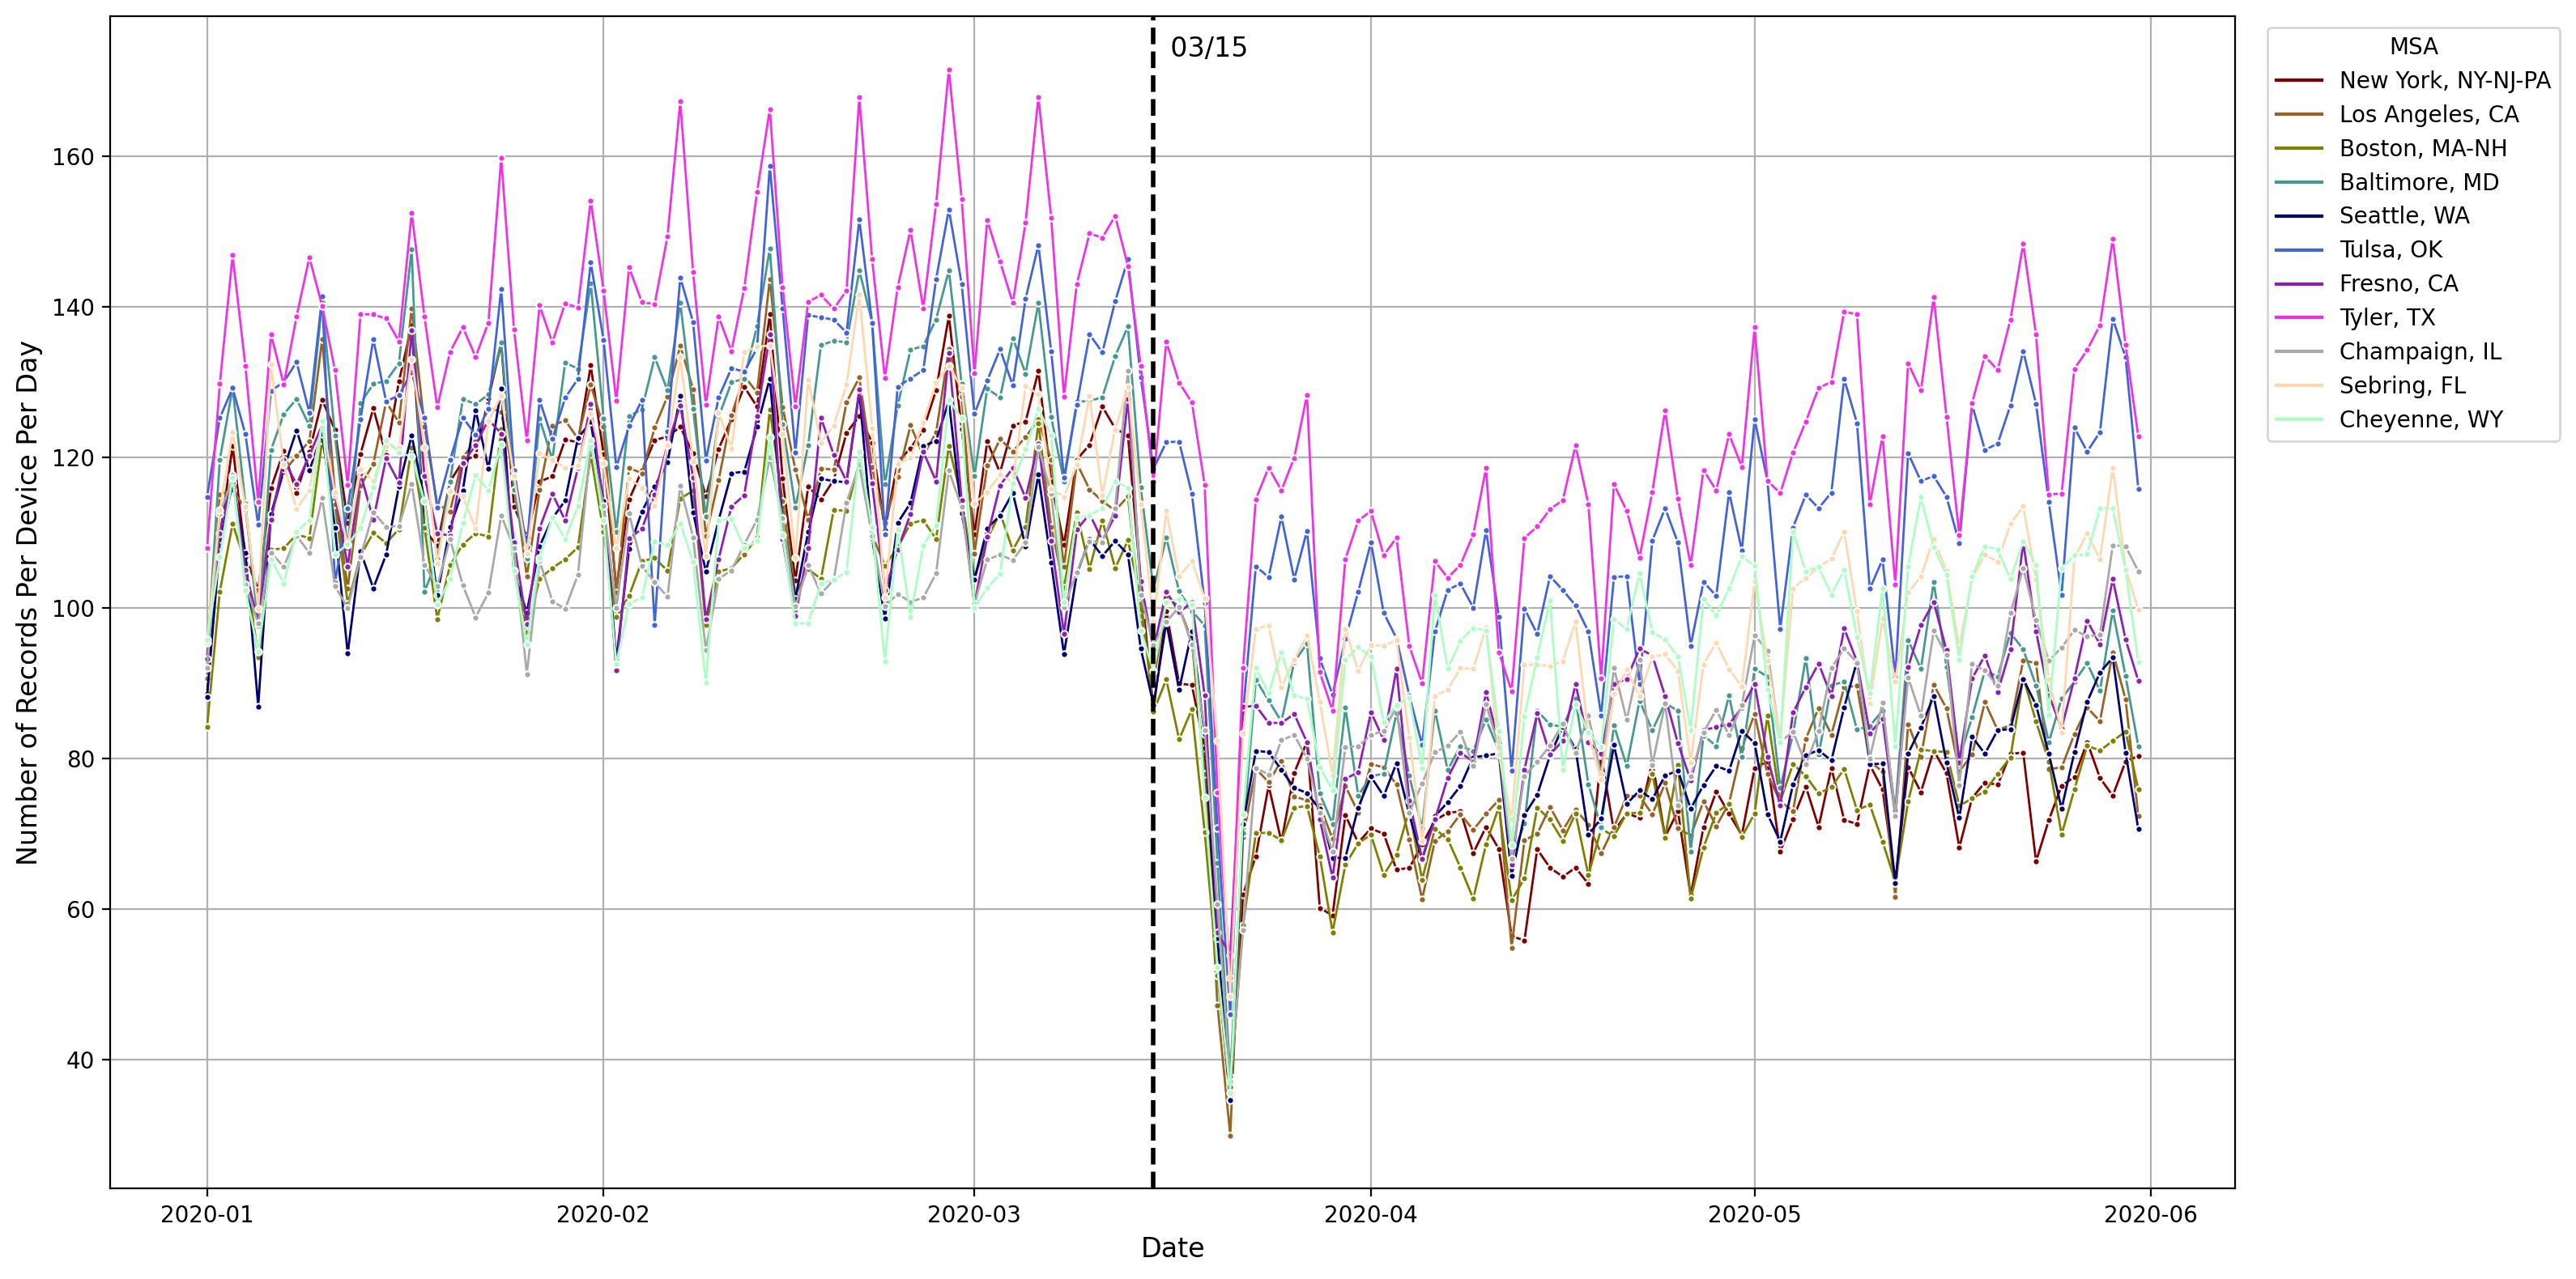

In [10]:
num_of_records_per_device_df_complete = daily_metrics_df_complete.groupby(['MSA','date']).num_of_records.mean().reset_index()
num_of_records_per_device_df_complete.columns = ['MSA','date','num_of_records_per_device']

num_of_records_per_device_df_complete['MSA'] = num_of_records_per_device_df_complete['MSA'].astype('string')

plt.figure(figsize=(16, 8),dpi=200)
sns.lineplot(data=num_of_records_per_device_df_complete, x='date', y='num_of_records_per_device', hue='MSA',marker='.', palette=palette, linestyle='-',linewidth=1)
# plt.title('Number of Records Per Device Over Time')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Records Per Device Per Day', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='MSA', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.axvline(pd.Timestamp('2020-03-15'), color='black', linestyle='--', lw=2)
plt.text(pd.Timestamp('2020-03-15'), num_of_records_per_device_df_complete['num_of_records_per_device'].max()*1.01, '  03/15', color='black', fontsize=12)

plt.grid(True)
plt.tight_layout()
# plt.savefig('Figures/Number_of_Records_Per_Device_Over_Time_complete.png')

# General characteristics

## Distribution of average number of records per day per user over 1 month

<Figure size 2400x1200 with 0 Axes>

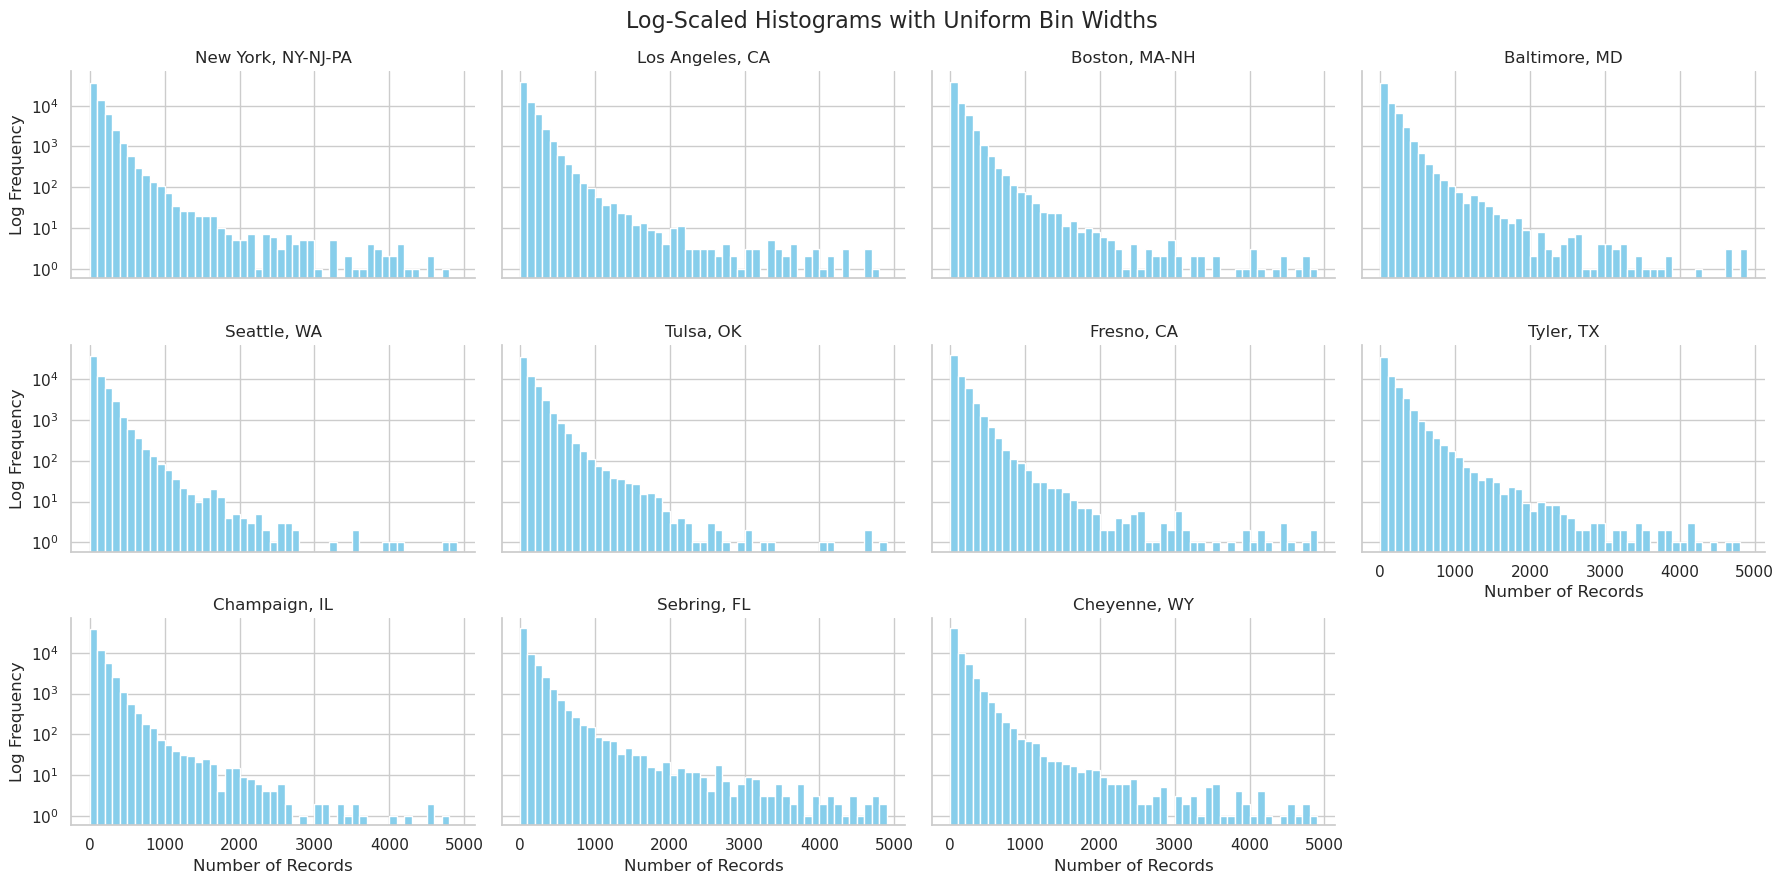

In [11]:
sampled_data = daily_metrics_df_complete[daily_metrics_df_complete.datetime.dt.month==1]  # Using JAN data

plt.figure(figsize=(12, 6),dpi=200)
sns.set(style="whitegrid")
g = sns.FacetGrid(sampled_data, col="MSA", col_wrap=4, height=3, aspect=1.5)
maximim_num_of_records = 5000
bin_edges = np.arange(0, maximim_num_of_records, 100)
g.map(plt.hist, "num_of_records", bins=bin_edges,color='skyblue', log=True)  # Using logarithmic scale

# Further customize the plot
g.set_titles("{col_name}")
g.set_axis_labels("Number of Records", "Log Frequency")
g.fig.subplots_adjust(top=0.9)  # Adjust subplot spacing
g.fig.suptitle('Log-Scaled Histograms with Uniform Bin Widths', fontsize=16)
plt.tight_layout()
plt.savefig('Figures/Log_Scaled_Histograms_with_Uniform_Bin_Widths.png')
plt.show()

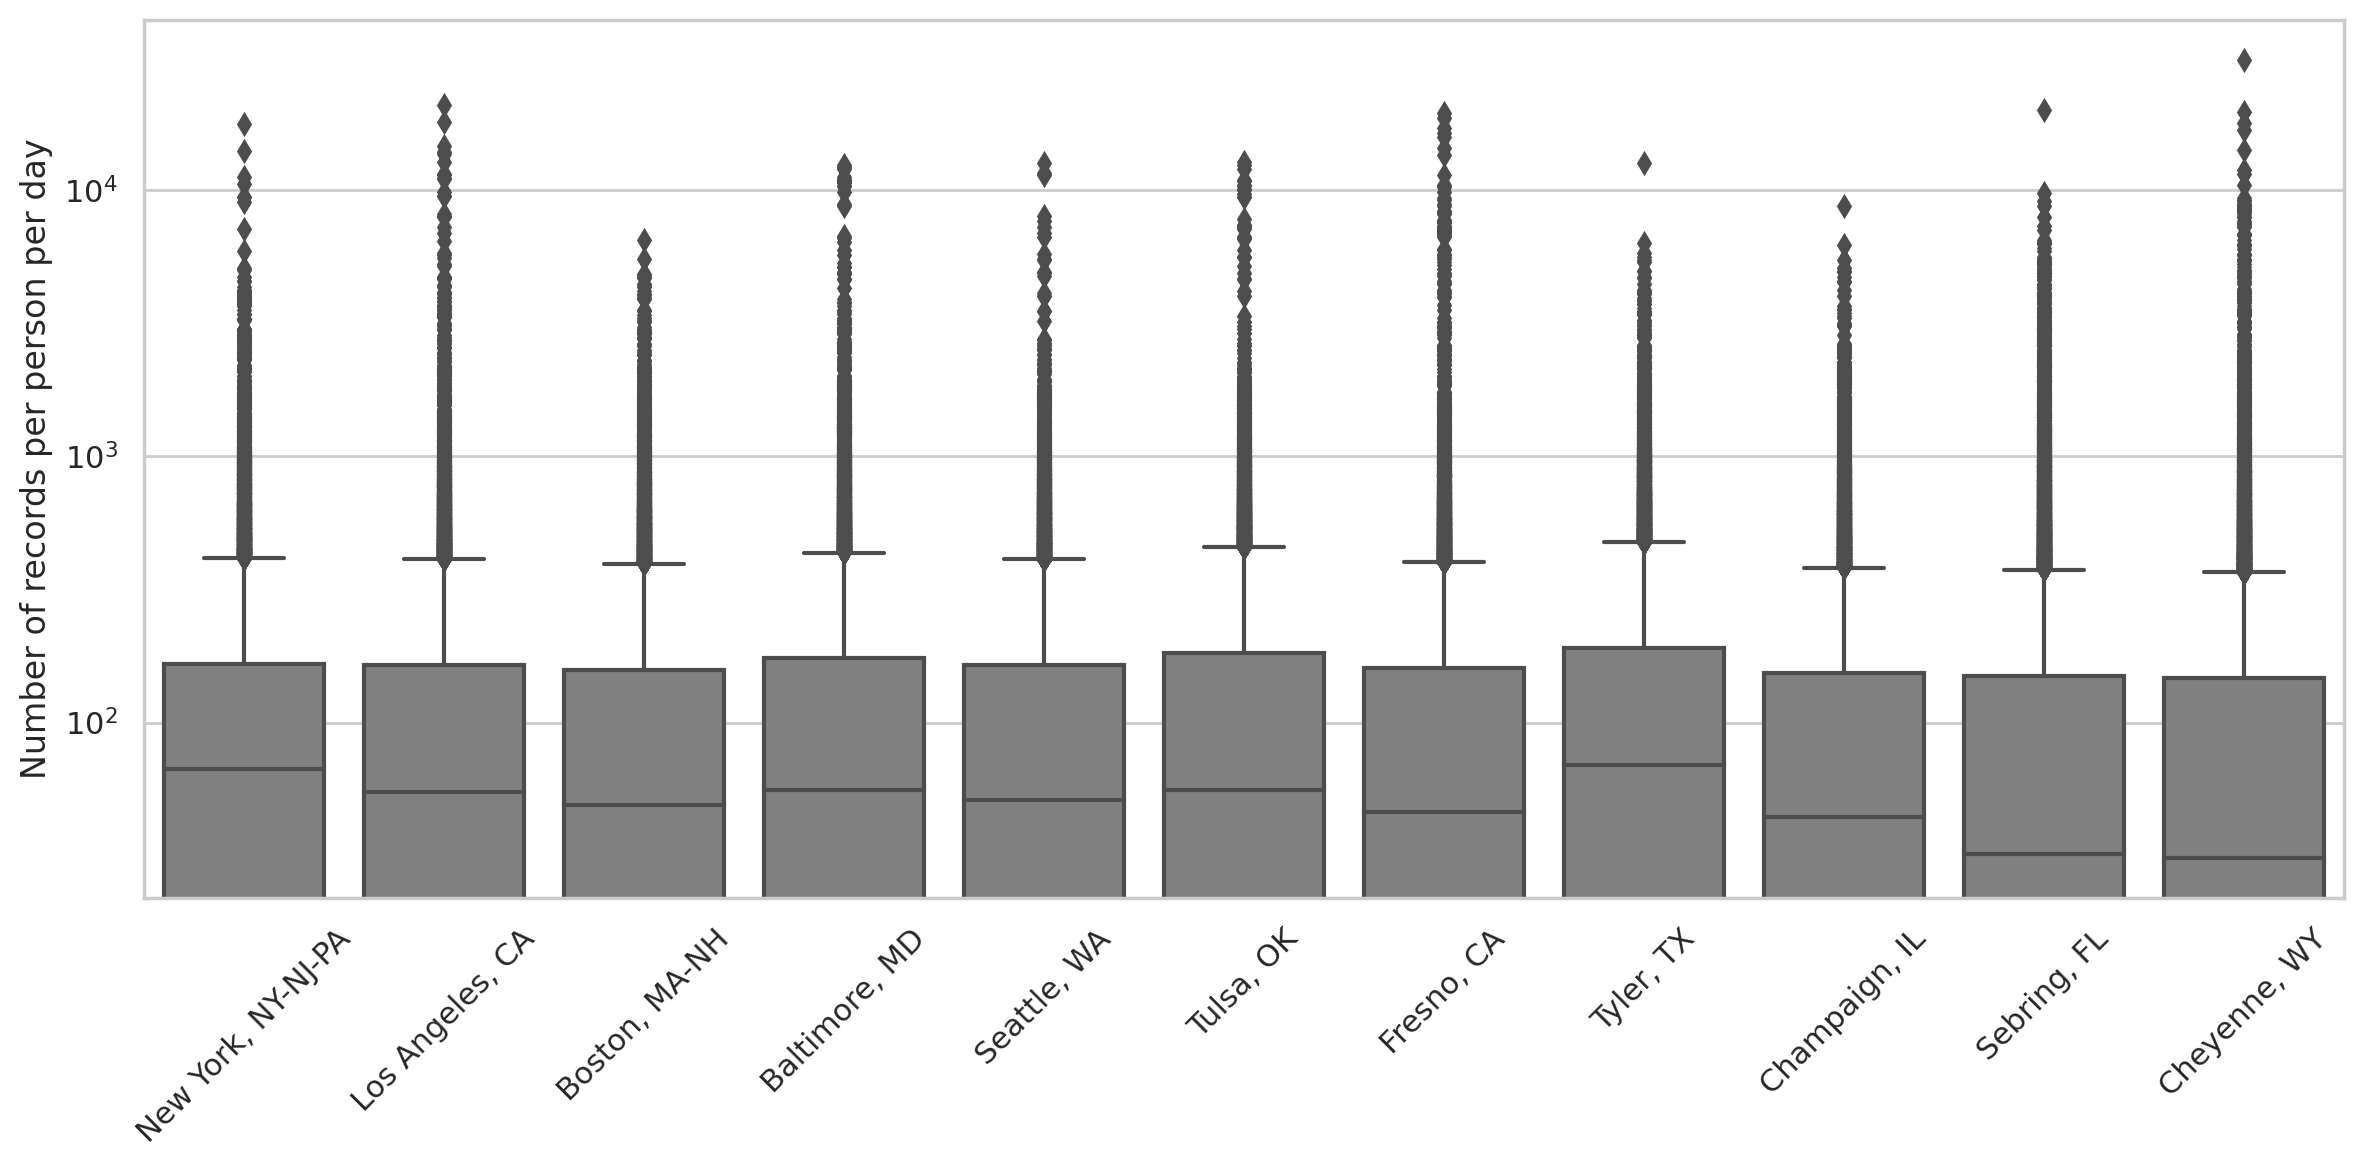

In [12]:
# Alternative of a boxplot for comparison
plt.figure(figsize=(12, 6),dpi=200)
sns.boxplot(x='MSA', y='num_of_records', data=sampled_data,color='grey')
plt.yscale('log')  # Applying log scale to y-axis
# plt.title('Boxplot of Number of Records per MSA on a Log Scale')
plt.xticks(rotation=45)  # Rotating x labels for better readability
plt.ylabel('Number of records per person per day')
plt.xlabel('',fontsize=0)
plt.tight_layout()
plt.savefig('Figures/Boxplot_of_Number_of_Records_per_MSA_on_a_Log_Scale.png')
plt.show()

# Temporal dimension

## Intra-day temporal occupancy

Here, we calculate temporal occupancy whithin a day (0-48) for each user and show the distribution

In [11]:
def plot_hist(data, bin_edges, color, **kwargs):
    # Calculate histogram data
    counts, _ = np.histogram(data, bins=bin_edges)
    # Convert counts to percentages
    counts = 100 * counts / float(counts.sum())
    # Generate the histogram plot with percentages
    plt.hist(bin_edges[:-1], bin_edges, weights=counts, color=color)

<Figure size 2400x1200 with 0 Axes>

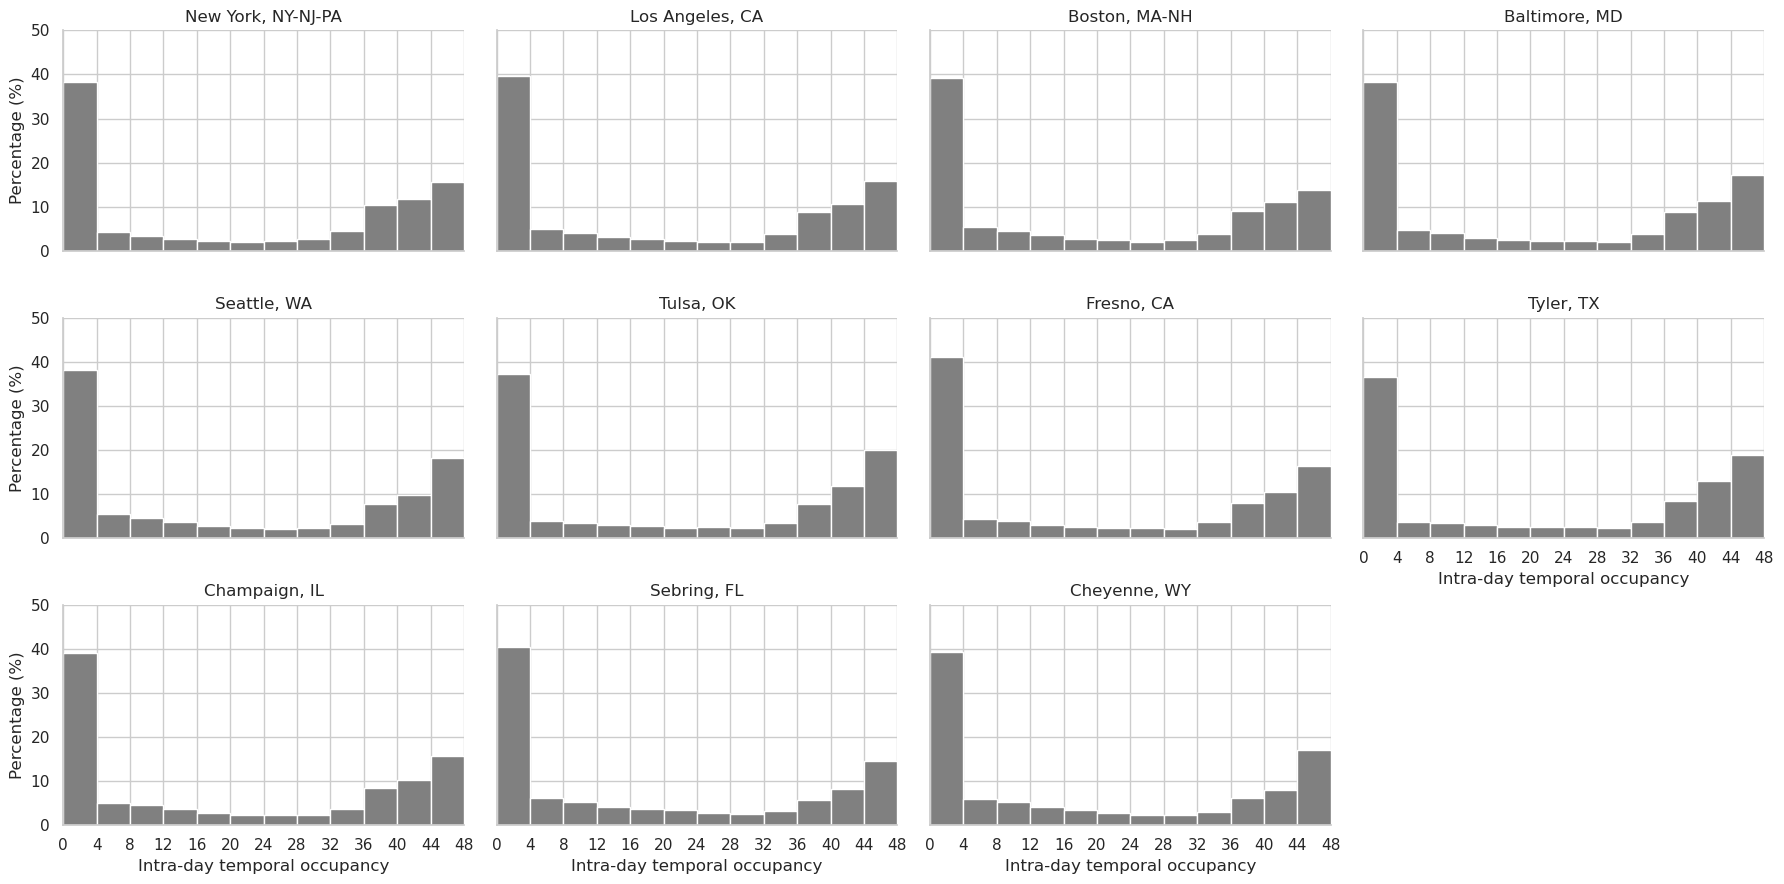

In [17]:
sampled_data = daily_metrics_df_complete.sample(frac=0.1)

plt.figure(figsize=(12, 6), dpi=200)
sns.set(style="whitegrid")

# Set up the FacetGrid
g = sns.FacetGrid(sampled_data, col="MSA", col_wrap=4, height=3, aspect=1.5)
bin_edges = np.arange(0, 49, 4)

# Use custom function to map the histograms
g.map(plot_hist, "intra_day_temporal_occupancy", bin_edges=bin_edges, color='grey')

# Set x-ticks at bin edges and customize further
for ax in g.axes.flatten():
    ax.set_xticks(bin_edges)  # Set x-ticks to bin edges
    ax.set_xlim([bin_edges[0], bin_edges[-1]])  # Optional: Limit x-axis to bin range for neatness
    ax.set_ylim([0, 50])  # Optional: Set y-axis to 0-100% for percentage scale
    ax.set_ylabel('Percentage (%)')  # Update y-axis label to reflect percentages

# Further customize the plot
g.set_titles("{col_name}")
g.set_axis_labels("Intra-day temporal occupancy", "Percentage (%)")
g.fig.subplots_adjust(top=0.9)  # Adjust subplot spacing
# g.fig.suptitle('Histograms of intra-day temporal occupancy by percentage', fontsize=16)

plt.tight_layout()
plt.savefig('Figures/Histograms_of_intra_day_temporal_occupancy.png')
plt.show()

## Inter-day temporal occupancy

Here, we calculate temporal occupancy whithin 6 month (0-100%) for each user and show the distribution

In [13]:
daily_metrics_df = pd.read_csv('Metrics/daily_metrics.csv')
daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
daily_metrics_df['MSA'] = daily_metrics_df['MSA'].map(MSA_dict)
inter_day_temporal_occupancy_df = daily_metrics_df.groupby(['user_id','MSA'])['intra_day_temporal_occupancy'].size().reset_index()
inter_day_temporal_occupancy_df.columns = ['user_id','MSA','inter_day_temporal_occupancy']
inter_day_temporal_occupancy_df['inter_day_temporal_occupancy'] = inter_day_temporal_occupancy_df['inter_day_temporal_occupancy']

<Figure size 2400x1200 with 0 Axes>

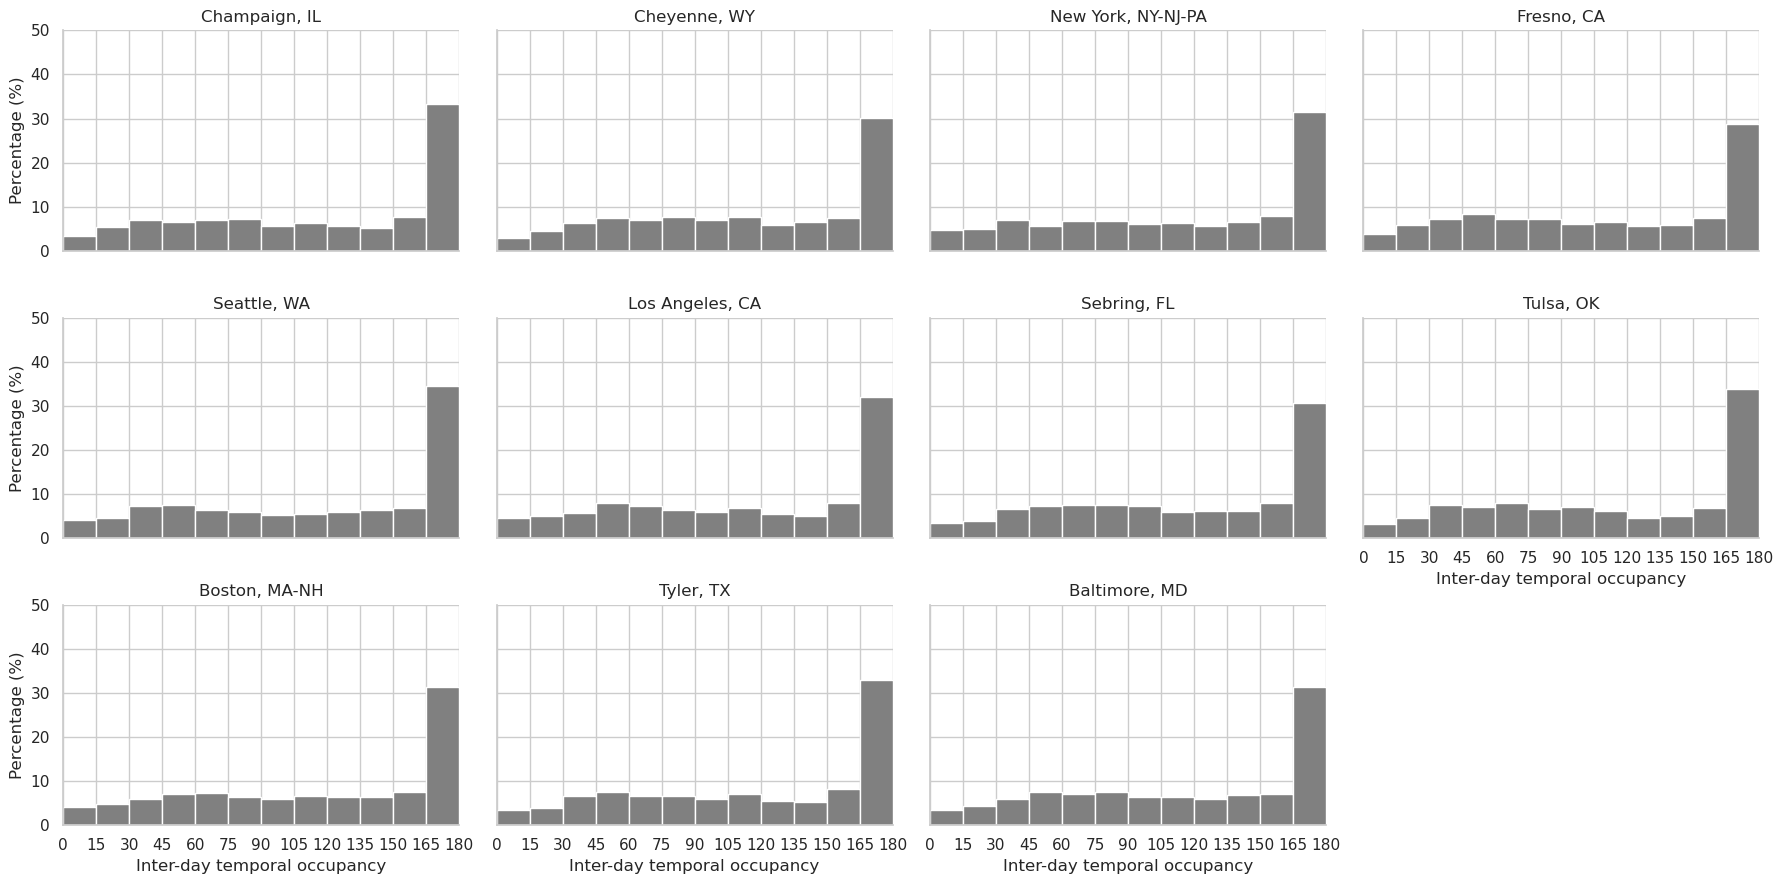

In [16]:
plt.figure(figsize=(12, 6), dpi=200)
sns.set(style="whitegrid")

# Set up the FacetGrid
g = sns.FacetGrid(inter_day_temporal_occupancy_df, col="MSA", col_wrap=4, height=3, aspect=1.5)
bin_edges = np.arange(0, 181, 15)

# Use custom function to map the histograms
g.map(plot_hist, "inter_day_temporal_occupancy", bin_edges=bin_edges, color='grey')

# Set x-ticks at bin edges and customize further
for ax in g.axes.flatten():
    ax.set_xticks(bin_edges)  # Set x-ticks to bin edges
    ax.set_xlim([bin_edges[0], bin_edges[-1]])  # Optional: Limit x-axis to bin range for neatness
    ax.set_ylim([0, 50])  # Optional: Set y-axis to 0-100% for percentage scale
    ax.set_ylabel('Percentage (%)')  # Update y-axis label to reflect percentages

# Further customize the plot
g.set_titles("{col_name}")
g.set_axis_labels("Inter-day temporal occupancy", "Percentage (%)")
g.fig.subplots_adjust(top=0.9)  # Adjust subplot spacing
# g.fig.suptitle('Histograms of intra-day temporal occupancy by percentage', fontsize=16)

plt.tight_layout()
plt.savefig('Figures/Histograms_of_inter_day_temporal_occupancy.png')
plt.show()

# Spatial dimension

In [17]:
longterm_metrics_df = pd.read_csv('Metrics/longterm_metrics.csv')
longterm_metrics_df['acc_rate'] *= 100
longterm_metrics_df['MSA'] = longterm_metrics_df['MSA'].map(MSA_dict)

## % of records with high precision

In [18]:
acc_df = pd.read_csv('Metrics/acc.csv')
acc_df['MSA'] = acc_df['MSA'].map(MSA_dict)

<Figure size 2400x1200 with 0 Axes>

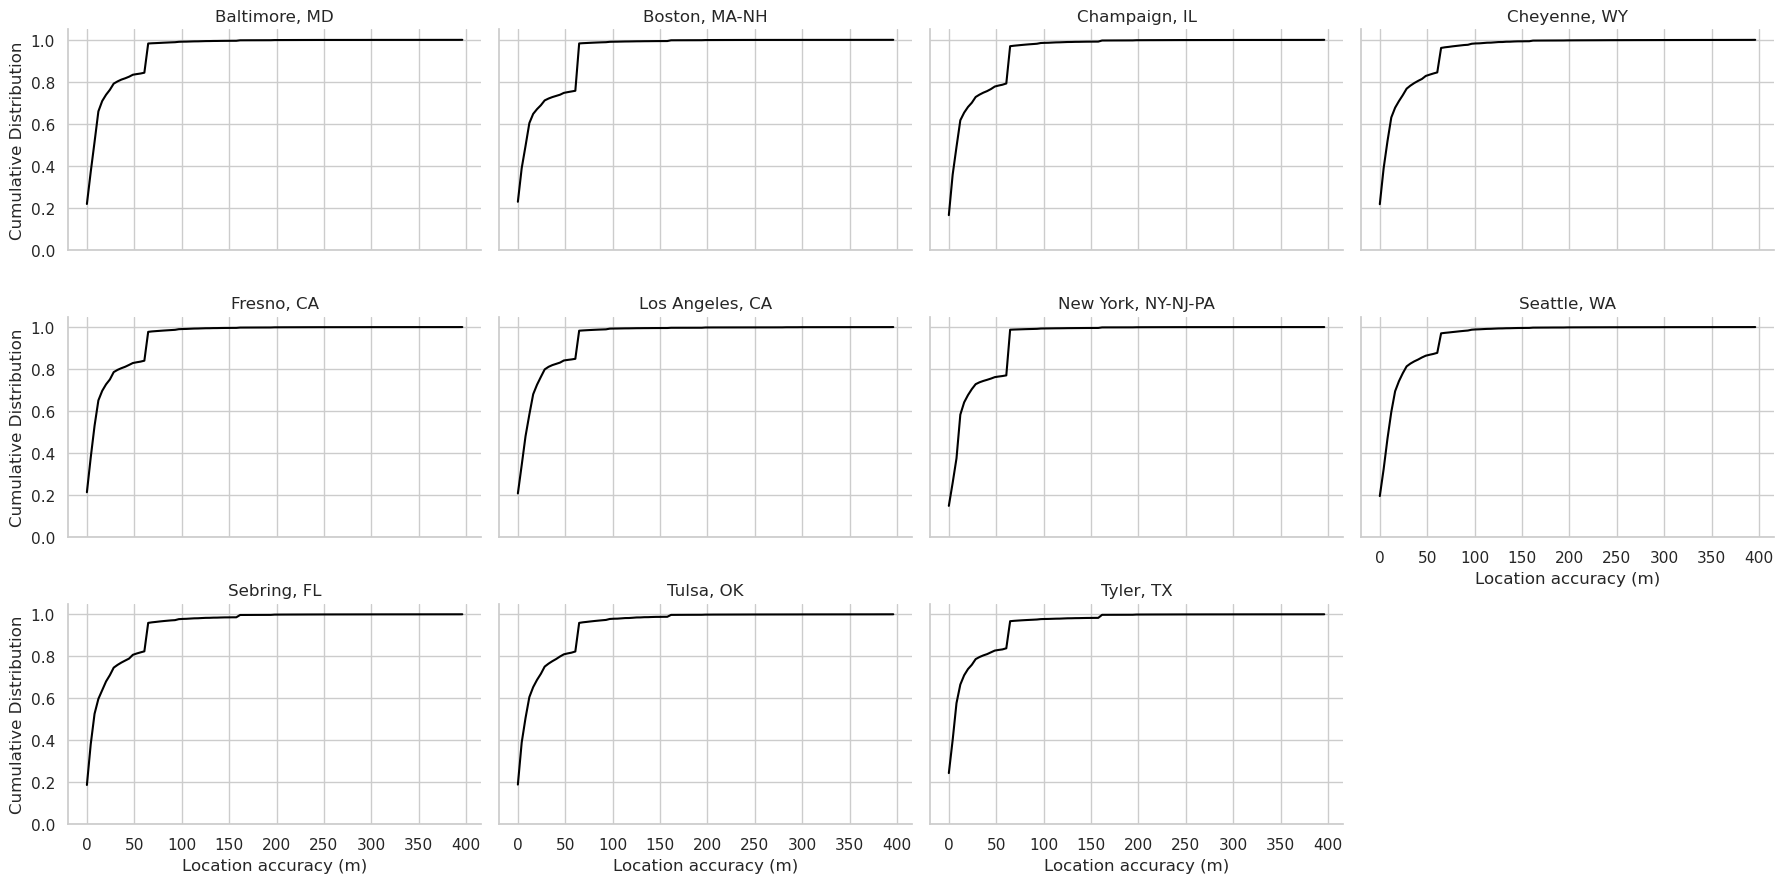

In [36]:
acc_df = acc_df[acc_df['acc'] >= 0] 
acc_df['acc'] = pd.to_numeric(acc_df['acc'], errors='coerce')
acc_df.dropna(subset=['acc'], inplace=True)

# Plot settings
plt.figure(figsize=(12, 6), dpi=200)
sns.set(style="whitegrid")
g = sns.FacetGrid(acc_df, col="MSA", col_wrap=4, height=3, aspect=1.5)

# Plotting function
def cdf_plot(data, **kwargs):
    x = data['acc']
    if pd.api.types.is_numeric_dtype(x):
        bin_edges = np.linspace(0, 400, 100)
        hist, _ = np.histogram(x, bins=bin_edges)
        cumulative = np.cumsum(hist) / hist.sum()
        plt.plot(bin_edges[:-1], cumulative, **kwargs)

# Apply the function to the DataFrame
g.map_dataframe(cdf_plot,color='black')
g.set_titles("{col_name}")
g.set_axis_labels("Location accuracy (m)", "Cumulative Distribution")
g.set(ylim=(0, 1.05))  # Extend ylim to show top boundary clearly
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('CDFs of Accuracy by MSA', fontsize=16)
plt.margins(y=0.05)  # Optional: adds margins
plt.tight_layout()
plt.savefig('Figures/CDFs_of_Accuracy_by_MSA.png')
plt.show()

## Euclidean distance mean

In [20]:
def convert_to_list(string):
    import re
    # Remove the square brackets and split the string on space
    return re.sub(r'[\[\]]', '', string).split()

In [21]:
jump_length_df = pd.read_csv('Metrics/jump_length.csv')
jump_length_df['MSA'] = jump_length_df['MSA'].map(MSA_dict)
jump_length_df['jump_length'] = jump_length_df['jump_length'].apply(convert_to_list)
jump_length_df = jump_length_df.explode('jump_length')
jump_length_df['jump_length'] = pd.to_numeric(jump_length_df['jump_length'], errors='coerce')
jump_length_df['jump_length'] += 1e-6  # Add a small value to avoid log(0)

start from 1 km

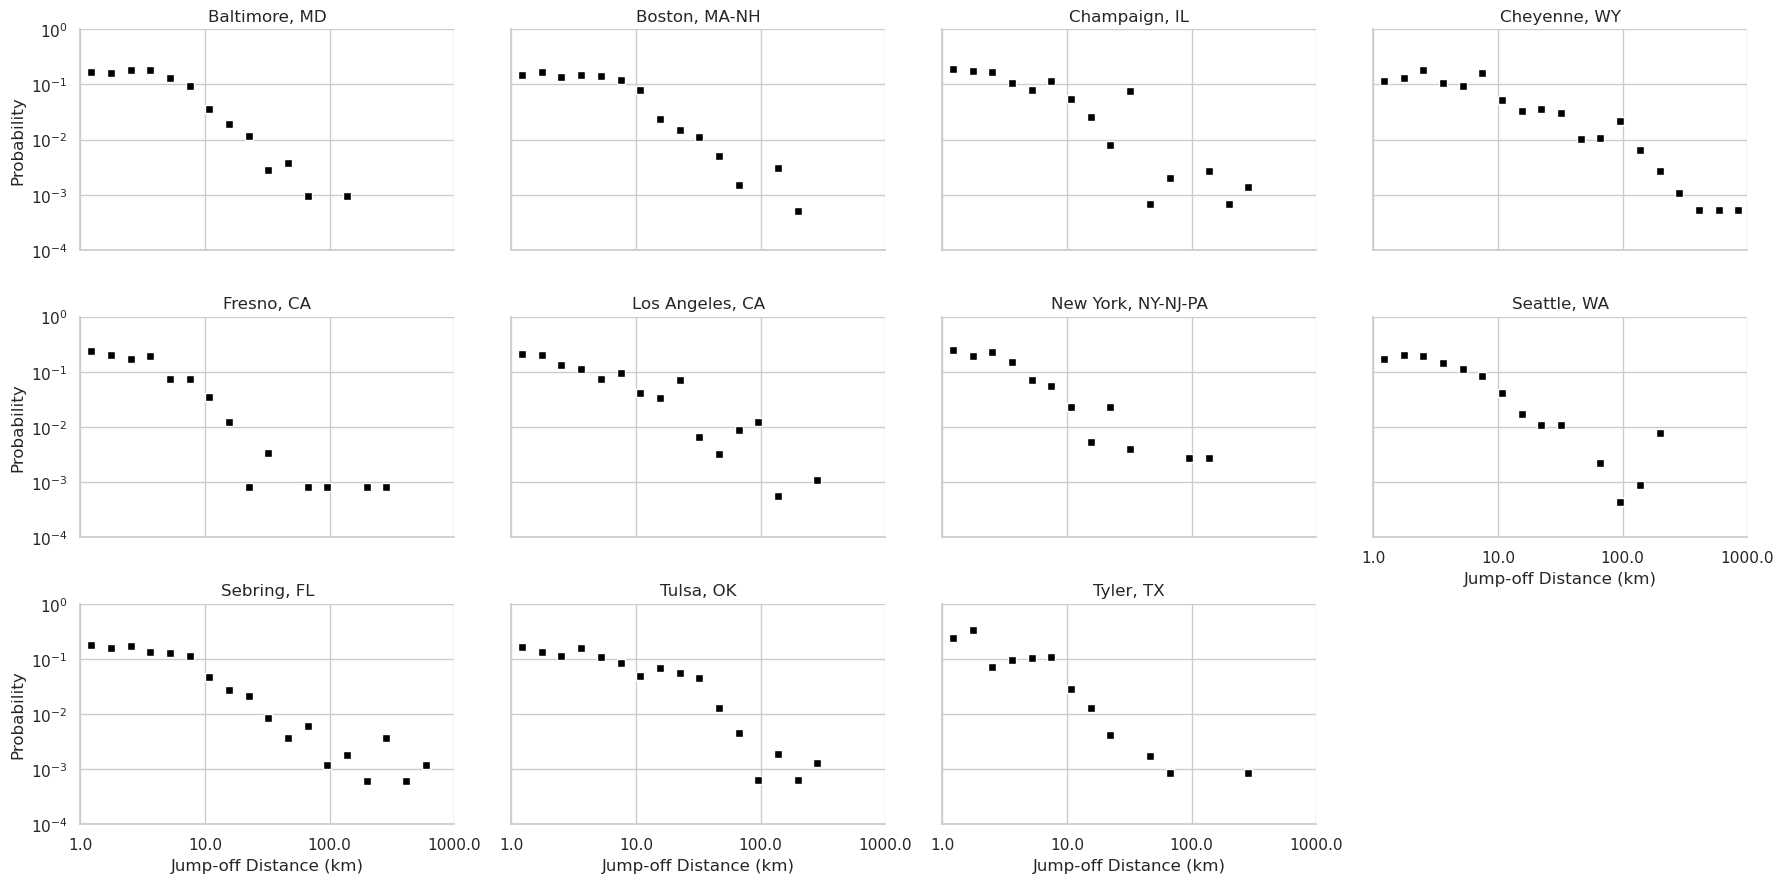

In [32]:
# Define bins on a log scale
bin_edges = np.logspace(np.log10(1), 
                        np.log10(1000), 20)

# Bin data and calculate statistics
jump_length_df['bin'] = pd.cut(jump_length_df['jump_length'], bins=bin_edges)
summary = jump_length_df.groupby(['MSA', 'bin']).size().reset_index(name='count')
summary['probability'] = summary.groupby('MSA')['count'].transform(lambda x: x / x.sum())
summary['mean'] = summary['bin'].apply(lambda x: x.mid)

# Setup FacetGrid
g = sns.FacetGrid(summary, col="MSA", col_wrap=4, height=3, aspect=1.5, margin_titles=True)
g.map(plt.scatter, 'mean', 'probability', color='black', edgecolor='w',marker='s')

# Customize and log scale
g.set(xscale="log", yscale="log")
g.set_axis_labels("Jump-off Distance (km)", "Probability")
g.set_titles(col_template="{col_name}")
for ax in g.axes:
    ax.set_xticks([1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlim([bin_edges.min(), bin_edges.max()])

# Adjust layout and save
g.fig.subplots_adjust(top=0.9)
g.set(ylim=(1e-4, 1e0))
# g.fig.suptitle('Detailed Log-Log Scatter Plots of Mean Distance vs. Probability for Each MSA', fontsize=16)
plt.tight_layout()
plt.savefig('Figures/Detailed_Log-Log_Scatter_Plots_for_Each_MSA.png')
plt.show()

start from 1 m

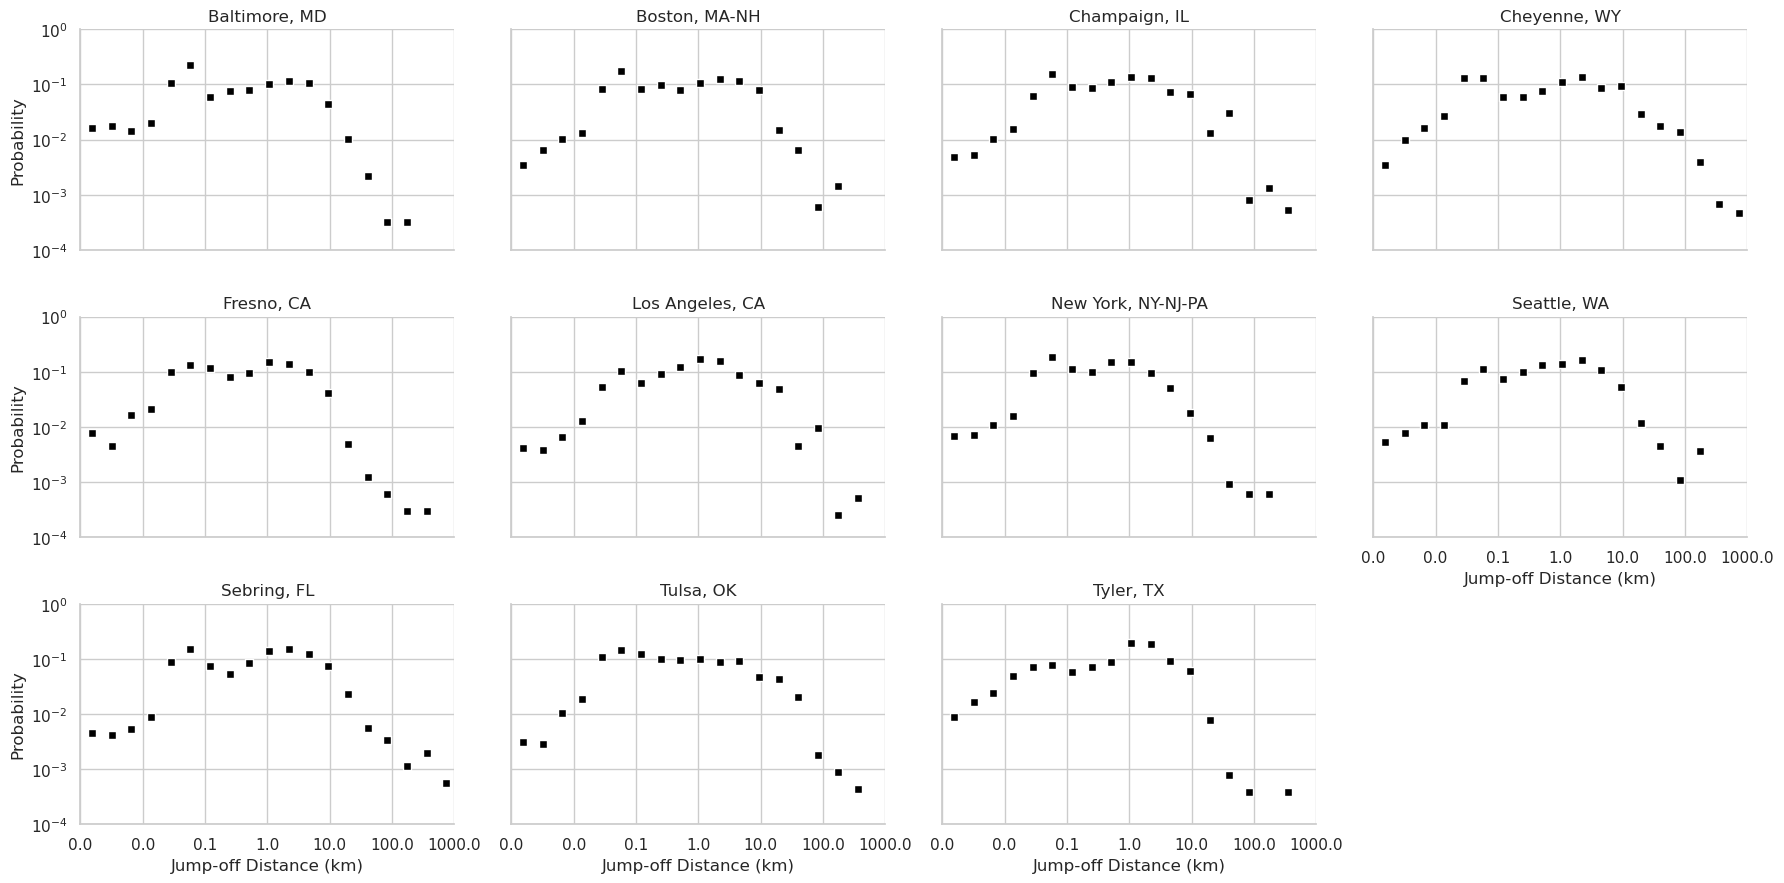

In [34]:
# Define bins on a log scale
bin_edges = np.logspace(np.log10(1e-3), 
                        np.log10(1000), 20)

# Bin data and calculate statistics
jump_length_df['bin'] = pd.cut(jump_length_df['jump_length'], bins=bin_edges)
summary = jump_length_df.groupby(['MSA', 'bin']).size().reset_index(name='count')
summary['probability'] = summary.groupby('MSA')['count'].transform(lambda x: x / x.sum())
summary['mean'] = summary['bin'].apply(lambda x: x.mid)

# Setup FacetGrid
g = sns.FacetGrid(summary, col="MSA", col_wrap=4, height=3, aspect=1.5, margin_titles=True)
g.map(plt.scatter, 'mean', 'probability', color='black', edgecolor='w',marker='s')

# Customize and log scale
g.set(xscale="log", yscale="log")
g.set_axis_labels("Jump-off Distance (km)", "Probability")
g.set_titles(col_template="{col_name}")
for ax in g.axes:
    ax.set_xticks([1e-3,1e-2,1e-1, 1e0, 1e1, 1e2, 1e3])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlim([bin_edges.min(), bin_edges.max()])

# Adjust layout and save
g.fig.subplots_adjust(top=0.9)
g.set(ylim=(1e-4, 1e0))
# g.fig.suptitle('Detailed Log-Log Scatter Plots of Mean Distance vs. Probability for Each MSA', fontsize=16)
plt.tight_layout()
plt.savefig('Figures/Detailed_Log-Log_Scatter_Plots_for_Each_MSA.png')
plt.show()